# REINFORCE in TensorFlow (3 pts)

Just like we did before for Q-learning, this time we'll design a TensorFlow network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate Q-learning, so you'll find it more or less familiar and even simpler.

In [1]:
import sys, os
if 'google.colab' in sys.modules:
    #%tensorflow_version 1.x
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/setup_colab.sh -O- | bash

        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package xvfb.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.4_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.4) ...
Setting up xvfb (2:1.19.6-1ubuntu4.4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A caveat: with some versions of `pyglet`, the following cell may crash with `NameError: name 'base' is not defined`. The corresponding bug report is [here](https://github.com/pyglet/pyglet/issues/134). If you see this error, try restarting the kernel.

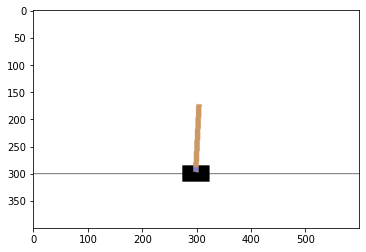

In [3]:
env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

In [4]:
print(n_actions)
print(state_dim)
print(state_dim[0])

2
(4,)
4


# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [5]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

sess = tf.InteractiveSession()

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
# create input variables. We only need <s, a, r> for REINFORCE
ph_states = tf.keras.backend.placeholder(dtype='float32', shape=(None,) + state_dim, name="states")
ph_actions = tf.keras.backend.placeholder(dtype='int32', name="action_ids")
ph_cumulative_rewards = tf.keras.backend.placeholder(dtype='float32', name="cumulative_returns")
ph_state_values = tf.keras.backend.placeholder(dtype='float32', name="state_values")

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Input

#<YOUR CODE: define network graph using raw TF, Keras, or any other library you prefer>

actor = Sequential([
        Dense(128, activation="relu", input_shape=(None,) + state_dim),
        Dense(64, activation="relu"),
        Dense(n_actions)
])

critic = Sequential([
        Dense(128, activation="relu", input_shape=(None,) + state_dim),
        Dense(64, activation="relu"),
        Dense(1)
])

logits_actions = actor(ph_states)
policy = tf.nn.softmax(logits_actions)
log_policy = tf.nn.log_softmax(logits_actions)

V_critic = critic(ph_states)

In [8]:
# Initialize model parameters
sess.run(tf.global_variables_initializer())

In [9]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    return policy.eval({ph_states: [states]})[0]

In [10]:
def predict_state_value(states):
    """ 
    Predict state values given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, 1]
    """
    return V_critic.eval({ph_states: [states]})[0]

### Play the game

We can now use our newly built agent to play the game.

In [11]:
def generate_session(env, t_max=1000):
    """ 
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards, state_values = [], [], [], []
    s = env.reset()

    pos_actions = list(range(n_actions))
    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(s)
        v_s = predict_state_value(s)[0]

        # Sample action with given probabilities.
        a = np.random.choice(pos_actions, p=action_probs)
        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        state_values.append(v_s)

        s = new_s
        if done:
            break

    return states, actions, rewards, state_values

In [12]:
# test it
states, actions, rewards, state_values = generate_session(env)
print(states[0])
print(actions)
print(rewards)
print(state_values)

[ 0.00061955 -0.02746257  0.03831938 -0.0179771 ]
[0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[-0.0010812961, -0.00598887, -0.012618724, -0.01870425, -0.023875095, -0.01461577, -0.00607178, -0.011082513, -0.0021241745, 0.007736674, 0.022022193, 0.0071749846, -0.004536923]


### Computing cumulative rewards

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

**Example**: For a trajectory $\tau = (s_0, a_0, r_0, s_1, a_1, r_1, ..., s_t, a_t, r_t, ..., s_T, a_T, r_T)$ the cumulative discounted rewards 
$$R(\tau) = \sum_{i=0}^T \gamma^i r_i \approx 
\gamma^{T} V_\phi(s_{T}) + \sum_{i=0}^{T-1} \gamma^i r_i$$ 
where $V_\phi$ is our critic.

In [13]:
def get_cumulative_rewards(rewards,    # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).
    
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    n = len(rewards)
    cum_reward = np.zeros(n).astype(float)
    cum_reward[n-1] = rewards[n-1]

    for i in reversed(range(n-1)):
        cum_reward[i] = rewards[i] + gamma * cum_reward[i+1]
        
    return cum_reward #<array of cumulative rewards>

In [14]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse Tensorflow's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

### Theory
The cumulative discounted reward has a high variance and therefore **REINFORCE** needs lots of trajectories to converge.
In order to reduce it we can substract a baseline $b(s_t)$.

This is possible because:

$$\mathbb{E}_{a_t \sim \pi_{\theta}}{\nabla_{\theta} \log \pi_{\theta}(a_t|s_t) b(s_t)} = 0.$$

**Proof**

Let $P_\theta$ be the parameterized probability distribution over a random variable x.
$$\int_x P_\theta (x) = 1$$
Taking the gradient we get: $\nabla_\theta \int_x P_\theta (x) = \nabla_\theta 1 = 0$ and
$$
0 = \nabla_\theta \int_x P_\theta (x)
= \int_x \nabla_\theta P_\theta(x)
= \int_x P_\theta (x) \nabla_\theta \log P_\theta (x)
= \mathbb{E}_{x \sim P_\theta} \nabla_\theta \log P_\theta (x)
$$

Which leads to the following formula:

$$ \nabla_{\theta} J(\pi_{\theta}) = \mathbb{E}_{\tau \sim \pi_{\theta}}{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) \left(\sum_{t'=t}^T \gamma^{t' - t} R(s_{t'}, a_{t'}, s_{t'+1}) - b(s_t)\right)}$$

The most common choice of baseline is the on-policy value function $V^{\pi}(s_t)$. This choice has the desirable effect of reducing variance in the sample estimate for the policy gradient. This results in faster and more stable policy learning. It is also appealing from a conceptual angle: it encodes the intuition that if an agent gets what it expected, it should “feel” neutral about it.

However $V^\pi$ is unknown and therefore we need to learn it. We will use a neural network to approximate $V^\pi$ with Mean Square Error as the loss function.

$$ \arg \min_{\phi} \mathbb{E}_{s_t, \hat{R}_t \sim \pi_k}{\left( V_{\phi}(s_t) - \hat{R}_t \right)^2}, $$


We can show that we can replace $\sum_{t'=t}^T \gamma^{t' - t} R(s_{t'}, a_{t'}, s_{t'+1})$ in the formula above by $Q^{\pi_\theta}(s_t, a_t)$ and by doing so we finally get $$ \nabla_{\theta} J(\pi_{\theta}) = \mathbb{E}_{\tau \sim \pi_{\theta}}{\sum_{t=0}^{T} \nabla_{\theta} \log \pi_{\theta}(a_t |s_t) \left(Q^{\pi_\theta}(s_t, a_t) - V^{\pi_\theta}(s_t)\right)}$$

**Bonus: Prove the statement above**

$A(s_t, a_t) = Q(s_{t}, a_{t}) - V^\pi(s_t)$ is called the Advantage function which gives the name **Advantage Actor Critic**.

$Q^{\pi_\theta}(s_t, a_t)$ is approximated as the cumulative sum of rewards.

Minh et al. in their paper explained that they added an entropy term to the loss in order to encourage exploration.

$$ - \sum_{a} \pi(a | s) \log \pi(a | s) $$

**Q.6: Explain why adding the entropy term encourage exploration.**

In [15]:
# This code selects the log-probabilities (log pi(a_i|s_i)) for those actions that were actually played.
indices = tf.stack([tf.range(tf.shape(log_policy)[0]), ph_actions], axis=-1)
log_policy_for_actions = tf.gather_nd(log_policy, indices)

In [16]:
print(indices)
print(log_policy_for_actions)

Tensor("stack:0", shape=(?, 2), dtype=int32)
Tensor("GatherNd:0", shape=(?,), dtype=float32)


In [17]:
# Policy objective as in the last formula. Please use reduce_mean, not reduce_sum.
# You may use log_policy_for_actions to get log probabilities for actions taken.
# Also recall that we defined ph_cumulative_rewards earlier.

# Advantage
advantage = ph_cumulative_rewards - ph_state_values

# Value - L2 squared loss
value_l2_squared_loss = tf.reduce_mean(tf.pow(advantage, 2))

J = tf.reduce_mean(log_policy_for_actions * advantage)

As a reminder, for a discrete probability distribution (like the one our policy outputs), entropy is defined as:

$$ \operatorname{entropy}(p) = -\sum_{i = 1}^n p_i \cdot \log p_i $$

In [18]:
# Entropy regularization. If you don't add it, the policy will quickly deteriorate to
# being deterministic, harming exploration.

#entropy = <YOUR CODE: compute entropy. Do not forget the sign!>
entropy = tf.reduce_mean(-tf.reduce_sum(policy * log_policy, axis=-1))

In [19]:
# # Maximizing X is the same as minimizing -X, hence the sign.
loss = -(J + 0.1 * entropy) + value_l2_squared_loss

update = tf.train.AdamOptimizer().minimize(loss)

In [20]:
def train_on_session(states, actions, rewards, state_values):
    """given full session, trains agent with policy gradient"""
    cumulative_rewards = get_cumulative_rewards(rewards)
    update.run({
        ph_states: states,
        ph_actions: actions,
        ph_cumulative_rewards: cumulative_rewards,
        ph_state_values: state_values
    })
    return np.sum(rewards)

In [21]:
# Initialize optimizer parameters
sess.run(tf.global_variables_initializer())

### The actual training

In [22]:
for i in range(50):
    
    c_rewards = []
    for j in range(100):
        states, actions, rewards, state_values = generate_session(env)
        r = train_on_session(states, actions, rewards, state_values)
        c_rewards.append(r)
    
    mean_reward = np.mean(c_rewards)
    print("mean reward: %.3f" % (mean_reward))

    if mean_reward >= 1000:
        print("You Win!!!")  # but you can train even further
        break
print("You Win!")

mean reward: 32.520
mean reward: 46.810
mean reward: 86.760
mean reward: 120.620
mean reward: 326.080
mean reward: 512.740
mean reward: 634.650
mean reward: 110.340
mean reward: 902.210
mean reward: 974.360
mean reward: 955.720
mean reward: 486.150
mean reward: 116.800
mean reward: 129.230
mean reward: 151.510
mean reward: 141.440
mean reward: 119.810
mean reward: 128.620
mean reward: 259.620
mean reward: 425.950
mean reward: 1000.000
mean reward: 1000.000


KeyboardInterrupt: ignored

### Results & video

In [23]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor) for _ in range(100)]

In [24]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices